In [1]:
import numpy as np
import wget 


In [2]:
# url = "https://images.unsplash.com/photo-1561731216-c3a4d99437d5?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=928&q=80"
# IMG_PATH = wget.download(url)

In [3]:
# class Processing:

#         def __init__(self, img_shape:tuple):
            

# import cv2
# from PIL import Image
# from PIL.Image import fromarray


# def load_and_prep_image(img_path, img_size=28):

#     img_array = plt.imread(img_path) #cv2.IMREAD_GRAYSCALE
#     plt.figure()
#     plt.imshow(img_array)
#     plt.title(f"Shape {img_array.shape}");
#     print(1160 * 928 * 3, "Value")
    
#     img_pil = fromarray(img_array)
#     img_resize = img_pil.resize((img_size, img_size), Image.ANTIALIAS)
#     img = np.array(img_resize)
    
#     plt.figure()
#     plt.imshow(img)
#     plt.title(f"Shape {img.shape}");
#     print(224 * 224 * 3, "Value")
#     return (img)

# img = load_and_prep_image(img_path=IMG_PATH, 
#                           img_size=224)
            

In [ ]:
from keras.layers import Dense

X = np.zeros(shape=(1, 200))
layer = Dense(units=50)
z = layer(X)

np.array(layer.bias).shape

In [50]:
layer.weights[0].shape, layer.weights[1].shape

(TensorShape([200, 50]), TensorShape([50]))

In [78]:
X = np.zeros(shape=(200))
W = np.ones(shape=(200, 50))
b = np.zeros(shape=(50))

T = W + b

Z = np.dot(X, W) + b

T.shape, Z.shape

((200, 50), (50,))

### Layer Perceptron
- init all Layer shape with list
- ~~init Weight~~
- ~~Create Activation~~
    - ~~softmax~~
    - ~~sigmoid~~
    - ~~relu~~
    - ~~linear~~
- Create forward Prop
- Create Backward Prop

In [57]:
import tensorflow as tf
import numpy as np
from keras.initializers import GlorotUniform
import matplotlib.pyplot as plt
import math

def initialize_weight(input_shape : int, output_shape: int):
        """Initialize Layer Weight with Xavier Initialization

        Args:
            input_shape (int): dimension of input
            output_shape (int): dimension of output

        Returns:
            W : Numpy Array Weight of Layer
        """
        limit_value = np.sqrt(6 / (input_shape + output_shape))

        min_value = -limit_value
        max_value = limit_value
        
        W = np.random.uniform(low =min_value,
                              high=max_value,
                              size=(input_shape, output_shape))
        W = W.astype(np.float32)

        return (W)
    
def initialize_bias(weight_output_shape : int):
    """Initialize the Bias Vector with Zeros

    Args:
        weight_output_shape  (int): output dimension of Weight Matrix

    Returns:
        b : Numpy Array of Zeros
    """
    b = np.zeros(shape=(weight_output_shape))

    return (b)

In [71]:
class Sigmoid:
    
    def __init__(self):
        pass
    def __call__(self, x):
        return (1 / (1 + tf.exp(- x)))

class ReLU:
    def __init__(self):
        pass
    def __call__(self, x):
        return (tf.maximum(0, x))

class SoftMax:
    def __init__(self):
        pass
    def __call__(self, x):
        t = tf.math.exp(X)
        S = tf.reduce_sum(t, axis=-1)
        D = t / S
        return (D)

class Linear:
    def __init__(self):
        pass
    def __call__(self, x):
        return (x)
    
def choose_activation(name : str):

        if (name == "sigmoid"):
            Activation = Sigmoid()

        elif (name == "relu"):
            Activation = ReLU()

        elif (name == "softmax"):
            Activation = SoftMax()

        else:
            Activation = Linear()
        
        return (Activation)

In [ ]:
# print(f"Input Shape {self.input_shape}")
# print(f"Weight Matrix {self.W.shape}")
# print(f"Bias Vector {self.b.shape}")
# print(f"Output Shape {self.output_shape}")
# plt.plot(x)
# plt.show()

# plt.plot(self.A(x))
# plt.show()

In [79]:
class Layer:
    
        def __init__(self, input_shape:int, output_shape:int, activation : str):

            self.input_shape = input_shape
            self.output_shape = output_shape
            self.W = initialize_weight(input_shape, output_shape)
            self.b = initialize_bias(weight_output_shape=self.W.shape[1])
            self.activation = choose_activation(activation)
            self.A = None
            self.Z = None
        
        def __call__(self, X):
            self.Z = np.dot(X, self.W) + self.b
            self.A = self.activation(self.Z)
            return (self.A)

(1, 200)


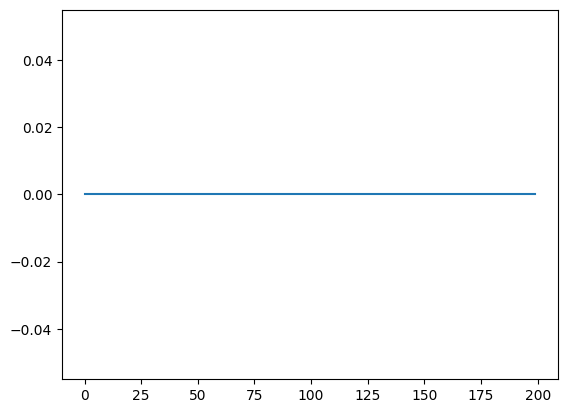

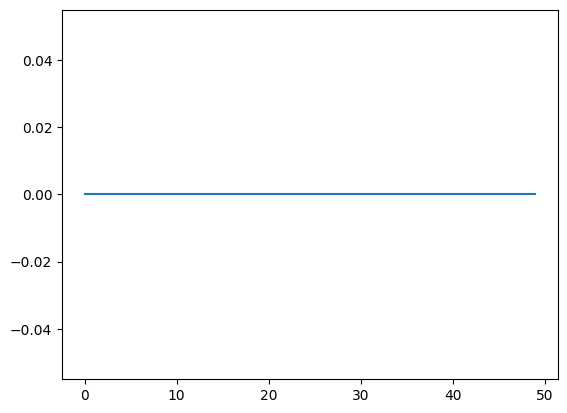

In [85]:
X = np.zeros(shape=(1, 200))
print(X.shape)

layer_1 = Layer(input_shape=X.shape[1],
                output_shape=50,
                activation="caca")

output = layer_1(X)

plt.figure()
plt.plot(X[0, :])
plt.show();
plt.figure()
plt.plot(output[0, :])
plt.show();

In [60]:
x = np.zeros((10))
layer_1(x)

Input Shape 10
Weight Matrix (10, 1)
Bias Vector (1,)
Output Shape 1


In [7]:
def initialize_layer(input_shape : int, output_shape : int):

        pass

Text(0, 0.5, 'Number of Weight')

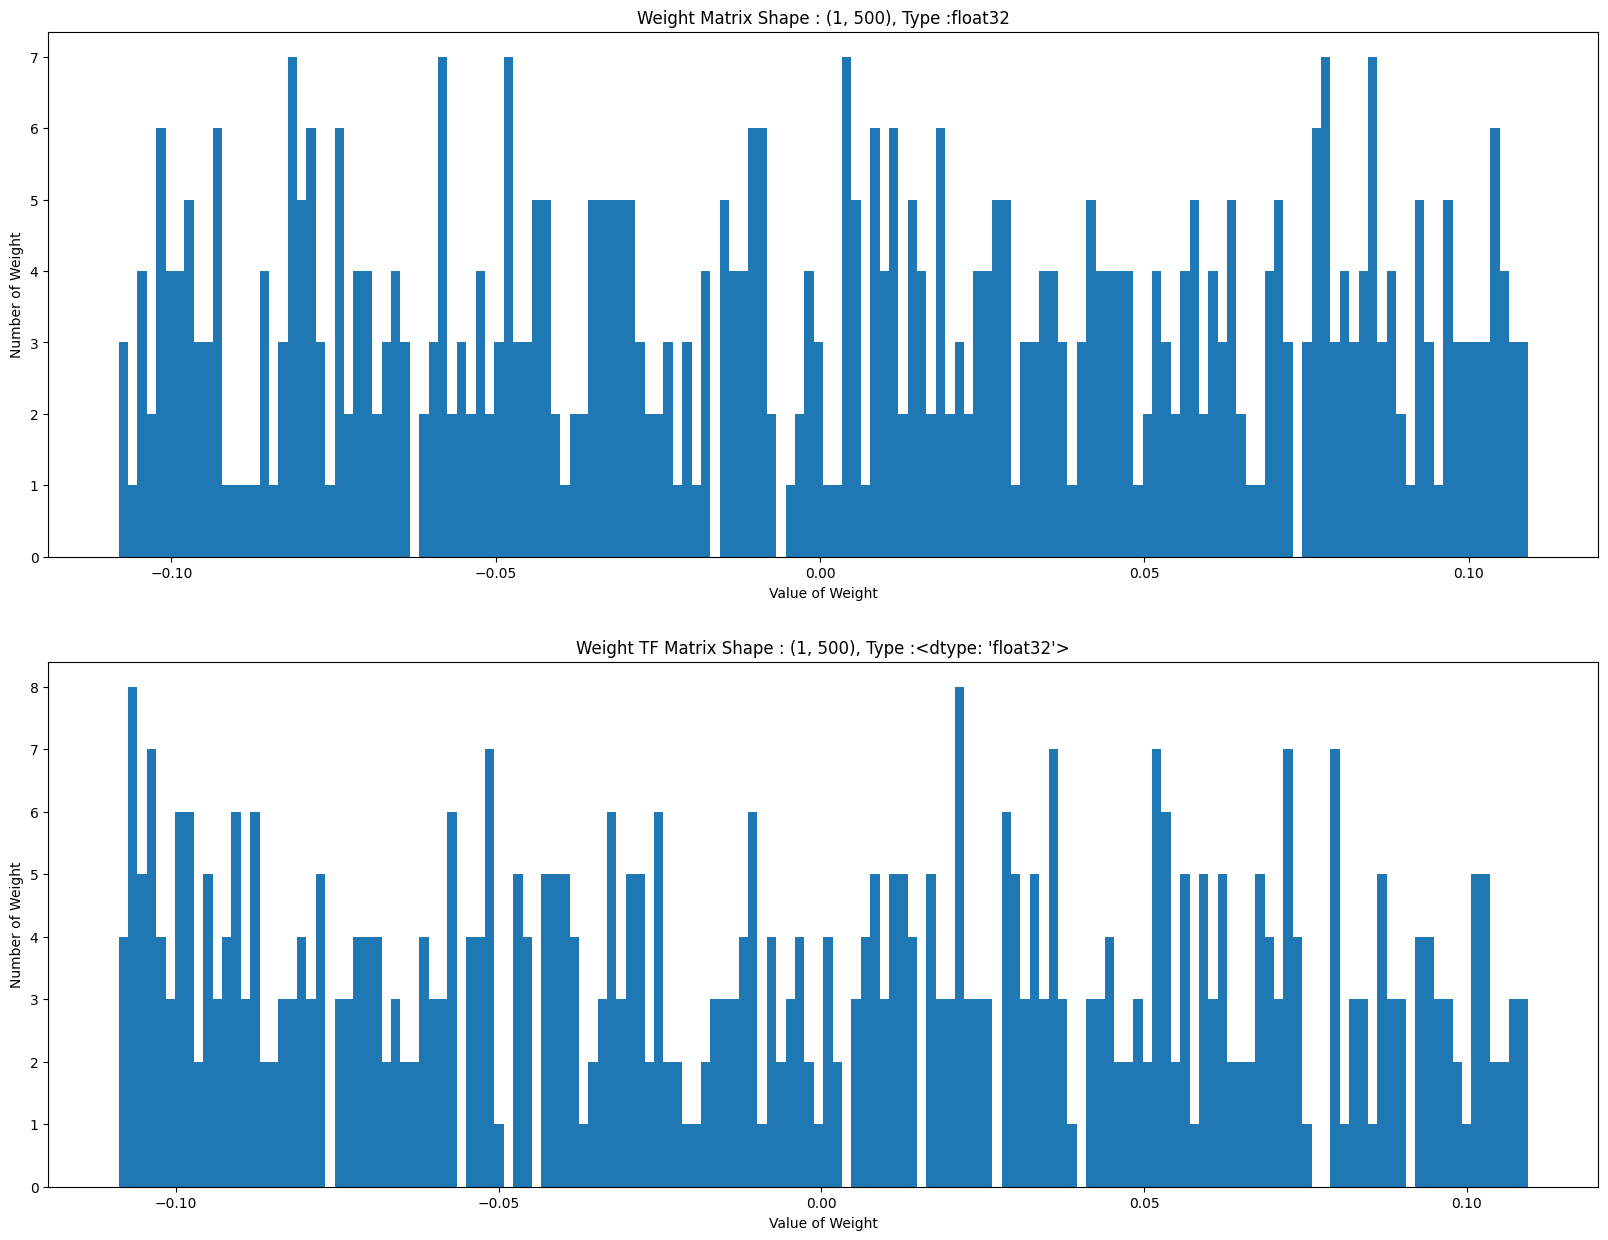

In [6]:
initializer = GlorotUniform()
W_tf = initializer(shape=(1, 500))

W = initialize_weight(input_shape=1,
                      output_shape=500)


plt.figure(figsize=(20, 15))

plt.subplot(2, 1, 1)
plt.hist(W[0, :], bins=150)
plt.title(f"Weight Matrix Shape : {W.shape}, Type :{W.dtype}")
plt.xlabel("Value of Weight")
plt.ylabel("Number of Weight")


plt.subplot(2, 1, 2)
plt.hist(W_tf[0, :], bins=150)
plt.title(f"Weight TF Matrix Shape : {W_tf.shape}, Type :{W_tf.dtype}")
plt.xlabel("Value of Weight")
plt.ylabel("Number of Weight")

KeyboardInterrupt: 

In [ ]:
class MultiLayerPerceptron:

        def __init__(self, input_shape: int, layer_config : list):

                self.input_shape = input_shape
                self.config = layer_config
        
        # Fit
        # Predict 
        
        def __call__(self, x):
            print(f"Our Model has {self.input_shape} input shape")
            print(f"Our Model has {self.config} Layer configuration Shape")
            # print(self.config)
        


In [ ]:
def initialize_network(layer_config : list):

        pass
        

In [ ]:
X = np.zeros((1, 1024))

X.shape

(1, 1024)

In [ ]:
model = Model(input_shape=X.shape[1],
              layer_config=[100, 50, 1])

model(X)

NameError: name 'Model' is not defined